# LibCBM versus CBM-CFS3 Stand level testing

In [1]:
import os, json, math
import numpy as np
import pandas as pd
%matplotlib inline


libCBM related imports

In [2]:
from libcbmwrapper import LibCBMWrapper
import libcbmconfig
import cbmconfig
import cbm_defaults
from cbm3 import CBM3

cbm3 related imports

In [3]:
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import sit_helper
from cbm3_python.cbm3data import cbm3_results

In [4]:
db_path = 'C:\dev\cbm_defaults\cbm_defaults.db'
n_steps = 225

age_interval = 5 #required by cbm3
num_age_classes = 40 #required by cbm3

def get_classifier_name(id):
    return str(id)

def growth_curve(x, x_0=65, L=250, k=0.1 ):
    return (x, L/(1+math.exp(-k*(x-x_0))))
    
def create_scenario(id, admin_boundary, eco_boundary, components, events):
    return {
        "id":id,
        "admin_boundary": admin_boundary,
        "eco_boundary": eco_boundary,
        "components": components,
        "events": events
    }

def generate_scenarios(random_seed, num_cases, dbpath, ndigits):
    np.random.seed(random_seed)
    species_ref = cbm_defaults.load_species_reference(dbpath, "en-CA")
    species = [k for k,v in species_ref.items() if len(k)<50 and v["forest_type_id"] in [1,3]] #exclude species names that are too long for the project database schema
    
    spatial_units = cbm_defaults.get_spatial_unit_ids_by_admin_eco_name(dbpath, "en-CA")
    random_spus = np.random.choice([",".join(x) for x in spatial_units.keys()], num_cases)
    
    disturbance_types = cbm_defaults.get_disturbance_type_ids_by_name(dbpath, "en-CA")
    
    cases = []
    for i in range(num_cases):
        num_components = np.random.randint(1,5)
        random_species = np.random.choice(list(species), num_components)
        spu = random_spus[i].split(',')
        components = []
        for c in range(num_components):
            components.append({
                "species": random_species[c],
                "age_volume_pairs": [growth_curve(x) for x in range(0,200,age_interval)]
            })

        num_disturbances = np.random.randint(0,3)
        random_dist_types = np.random.choice(list(disturbance_types), num_disturbances)
        disturbance_events = []
        min_timestep = 0
        for d in range(num_disturbances):
            
            disturbance_events.append({
             "disturbance_type": random_dist_types[d],
             "time_step": np.random.randint(min_timestep, n_steps)
            })
            
        cases.append(create_scenario(
            id = i+1,
            admin_boundary = spu[0],
            eco_boundary = spu[1],
            components = components,
            events = disturbance_events ))
    return cases

In [5]:
cases = generate_scenarios(1, 1, db_path, 2)

#pd.DataFrame({"x": list(range(0, 200 , 5)), "y": [growth_curve(x,65,100,0.1) for x in range(0, 200 , 5)]}).groupby("x").sum().plot()
#list(range(0, 200 , 20))

In [6]:
def run_libCBM(dbpath, cases, nsteps, spinup_debug = False):
    
    dllpath = r'C:\dev\LibCBM\LibCBM\x64\Debug\LibCBM.dll'

    dlldir = os.path.dirname(dllpath)
    cwd = os.getcwd()
    os.chdir(dlldir)
    dll = LibCBMWrapper(dllpath)
    os.chdir(cwd)
    
    pooldef = cbm_defaults.load_cbm_pools(dbpath)
    dll.Initialize(libcbmconfig.to_string(
        {
            "pools": pooldef,
            "flux_indicators": cbm_defaults.load_flux_indicators(dbpath)
        }))
    
    #create a single classifier/classifier value for the single growth curve
    classifiers_config = cbmconfig.classifier_config([
        cbmconfig.classifier("growth_curve", [
            cbmconfig.classifier_value(get_classifier_name(c["id"])) 
            for c in cases
        ])
    ])


    transitions_config = []
    species_reference = cbm_defaults.load_species_reference(dbpath, "en-CA")
    spatial_unit_reference = cbm_defaults.get_spatial_unit_ids_by_admin_eco_name(dbpath, "en-CA")
    disturbance_types = cbm_defaults.get_disturbance_type_ids_by_name(dbpath, "en-CA")
    curves = []
    for c in cases:
        classifier_set = [get_classifier_name(c["id"])]
        merch_volumes = []
        for component in c["components"]:
            merch_volumes.append({
                "species_id": species_reference[component["species"]]["species_id"],
                "age_volume_pairs": component["age_volume_pairs"]
            })

        curve = cbmconfig.merch_volume_curve(
            classifier_set = classifier_set,
            merch_volumes = merch_volumes)
        curves.append(curve)

    merch_volume_to_biomass_config = cbmconfig.merch_volume_to_biomass_config(
        dbpath, curves)

    dll.InitializeCBM(libcbmconfig.to_string({
        "cbm_defaults": cbm_defaults.load_cbm_parameters(dbpath),
        "merch_volume_to_biomass": merch_volume_to_biomass_config,
        "classifiers": classifiers_config["classifiers"],
        "classifier_values": classifiers_config["classifier_values"],
        "transitions": []
    }))

    nstands = len(cases)
    age = np.zeros(nstands,dtype=np.int32)
    classifiers = np.zeros((nstands,1),dtype=np.int32)
    classifiers[:,0]=[classifiers_config["classifier_index"][0][get_classifier_name(c["id"])] for c in cases]
         
    spatial_units = np.array(
        [spatial_unit_reference[(c["admin_boundary"],c["eco_boundary"])]
            for c in cases],dtype=np.int32)
    pools = np.zeros((nstands,len(pooldef)))
    cbm3 = CBM3(dll)
    pool_result = pd.DataFrame()
    
    spinup_debug = cbm3.spinup(
        pools=pools,
        classifiers=classifiers,
        inventory_age=0,
        spatial_unit=spatial_units,
        historic_disturbance_type=disturbance_types["Wildfire"],
        last_pass_disturbance_type=disturbance_types["Wildfire"],
        delay=0,
        mean_annual_temp=None,
        debug=spinup_debug)
    
    iteration_result = pd.DataFrame({x["name"]: pools[:,x["index"]] for x in pooldef})
    iteration_result.insert(0, "timestep", 0) 
    iteration_result.insert(0, "age", 0) #fix this, ages will be a random vector soon
    iteration_result.reset_index(level=0, inplace=True)
    pool_result = pool_result.append(iteration_result)
    
    return {"pools": pool_result, "spinup_debug": spinup_debug}

In [7]:
def run_CBM3(cases, age_interval, num_age_classes, nsteps):
    standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()

    toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"

    #there is a bug fix in this version of cbm/makelist for growth incrment blips
    cbm_exe_path = r"M:\CBM Tools and Development\Builds\CBMBuilds\20190530_growth_increment_fix"

    cbm3_project_dir = os.path.join(toolbox_path, "Projects", "libcbm_stand_level_testing")
    cbm3_project_path = os.path.join(cbm3_project_dir, "libcbm_stand_level_testing.mdb")
    cbm3_results_db_path = os.path.join(cbm3_project_dir, "libcbm_stand_level_testing_results.mdb")
    config_save_path = os.path.join(cbm3_project_dir, "libcbm_stand_level_testing.json")
    sit_config = sit_helper.SITConfig(
        imported_project_path=cbm3_project_path,
        initialize_mapping=True
    )
    sit_config.data_config(
        age_class_size=age_interval,
        num_age_classes=num_age_classes,
        classifiers=["admin", "eco", "identifier", "species"])
    sit_config.set_admin_eco_mapping("admin","eco")
    sit_config.set_species_classifier("species")
    for c in cases:
        cset = [c["admin_boundary"], c["eco_boundary"], get_classifier_name(c["id"]), "Spruce"]
        sit_config.add_inventory(classifier_set=cset, area=1, age=0, unfccc_land_class=0,
                            historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
        for component in c["components"]:
            sit_config.add_yield(classifier_set=cset, 
                        leading_species_classifier_value=component["species"],
                        values=[x[1] for x in component["age_volume_pairs"]])
        for event in c["events"]:
            sit_config.add_event(
                classifier_set=cset,
                disturbance_type=event["disturbance_type"],
                time_step=event["time_step"],
                target=1,
                target_type = "Area",
                sort = "SORT_BY_SW_AGE")
    sit_config.add_event(
        classifier_set=["?","?","?","?"],
        disturbance_type="Wildfire",
        time_step=nsteps+1,
        target=1,
        target_type = "Area",
        sort = "SORT_BY_SW_AGE")
    sit_config.import_project(standard_import_tool_plugin_path, config_save_path)
    cbm3_python.simulation.projectsimulator.run(
        aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
        project_path=cbm3_project_path, 
        toolbox_installation_dir=toolbox_path,
        cbm_exe_path=cbm_exe_path,
        results_database_path = cbm3_results_db_path)
    return cbm3_results_db_path
    

In [8]:
libCBM_result = run_libCBM(db_path, cases, n_steps, spinup_debug=True)
libCBM_pool_result = libCBM_result["pools"]
libCBM_pool_result["identifier"] = (libCBM_pool_result["index"]+1).apply(get_classifier_name)
libCBM_spinup_debug = libCBM_result["spinup_debug"]

In [9]:
cbm3_results_db_path = run_CBM3(cases, age_interval, num_age_classes, n_steps)
cbm3_pool_result = cbm3_results.load_pool_indicators(cbm3_results_db_path, classifier_set_grouping=True)

In [10]:
list(cbm3_pool_result)

['TimeStep',
 'UserDefdClassSetID',
 'Aboveground Very Fast DOM',
 'Belowground Very Fast DOM',
 'Aboveground Fast DOM',
 'Belowground Fast DOM',
 'Medium DOM',
 'Aboveground Slow DOM',
 'Belowground Slow DOM',
 'Softwood Stem Snag',
 'Softwood Branch Snag',
 'Hardwood Stem Snag',
 'Hardwood Branch Snag',
 'BlackCarbon',
 'Peat',
 'Softwood Merchantable',
 'Softwood Foliage',
 'Softwood Other',
 'Softwood Coarse Roots',
 'Softwood Fine Roots',
 'Hardwood Merchantable',
 'Hardwood Foliage',
 'Hardwood Other',
 'Hardwood Coarse Roots',
 'Hardwood Fine Roots',
 'Total Biomass',
 'Aboveground Biomass',
 'Belowground Biomass',
 'Total Ecosystem',
 'Dead Organic Matter',
 'Aboveground DOM',
 'Belowground DOM',
 'Deadwood',
 'Litter',
 'Soil C',
 'admin',
 'eco',
 'identifier',
 'species']

In [11]:

libCBM_pools = libCBM_pool_result[['identifier','timestep', 'SoftwoodMerch', 'SoftwoodFoliage', 
               'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
               'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
               'HardwoodCoarseRoots', 'HardwoodFineRoots', 'AboveGroundVeryFastSoil',
               'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil', 'MediumSoil',
               'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
               'HardwoodStemSnag', 'HardwoodBranchSnag']]

cbm3_pools = cbm3_pool_result[['identifier','TimeStep', 'Softwood Merchantable', 'Softwood Foliage',
             'Softwood Other', 'Softwood Coarse Roots', 'Softwood Fine Roots',
             'Hardwood Merchantable', 'Hardwood Foliage', 'Hardwood Other',
             'Hardwood Coarse Roots', 'Hardwood Fine Roots', 'Aboveground Very Fast DOM',
             'Belowground Very Fast DOM', 'Aboveground Fast DOM', 'Belowground Fast DOM', 'Medium DOM',
             'Aboveground Slow DOM', 'Belowground Slow DOM', 'Softwood Stem Snag', 'Softwood Branch Snag',
             'Hardwood Stem Snag', 'Hardwood Branch Snag']]

#make column naming consistent
cbm3_pools = cbm3_pools.rename(columns = {
    'Softwood Merchantable': 'SoftwoodMerch',
    'Softwood Foliage': 'SoftwoodFoliage',
    'Softwood Other': 'SoftwoodOther',
    'Softwood Coarse Roots': 'SoftwoodCoarseRoots',
    'Softwood Fine Roots': 'SoftwoodFineRoots',
    'Hardwood Merchantable': 'HardwoodMerch',
    'Hardwood Foliage': 'HardwoodFoliage',
    'Hardwood Other': 'HardwoodOther',
    'Hardwood Coarse Roots': 'HardwoodCoarseRoots',
    'Hardwood Fine Roots': 'HardwoodFineRoots',
    'Aboveground Very Fast DOM': "AboveGroundVeryFastSoil",
    'Belowground Very Fast DOM': "BelowGroundVeryFastSoil",
    'Aboveground Fast DOM': "AboveGroundFastSoil",
    'Belowground Fast DOM': "BelowGroundFastSoil",
    'Medium DOM': "MediumSoil",
    'Aboveground Slow DOM': "AboveGroundSlowSoil",
    'Belowground Slow DOM': "BelowGroundSlowSoil",
    'Softwood Stem Snag': "SoftwoodStemSnag",
    'Softwood Branch Snag': "SoftwoodBranchSnag",
    'Hardwood Stem Snag': "HardwoodStemSnag",
    'Hardwood Branch Snag': "HardwoodBranchSnag"})

merged = libCBM_pools.merge(cbm3_pools,
                              left_on=['identifier','timestep'],
                              right_on=['identifier','TimeStep'],
                              suffixes=("_libCBM","_cbm3"))

diff_colnames = []
cbm3_colnames = []
libCBM_colnames = []
merged["total_diff"]=0
#compute diffs row-by-row
for pool in ['SoftwoodMerch', 'SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots',
             'SoftwoodFineRoots','HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
             'HardwoodCoarseRoots', 'HardwoodFineRoots','AboveGroundVeryFastSoil',
             'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil', 'MediumSoil',
             'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']:
    
    d = "{}_diff".format(pool)
    l = "{}_libCBM".format(pool)
    r = "{}_cbm3".format(pool)
    diff_colnames.append(d)
    cbm3_colnames.append(r)
    libCBM_colnames.append(l)
    merged[d] = (merged[l] - merged[r])
    merged["total_diff"]+=merged[d].abs()
merged["total_diff"] = merged["total_diff"]

In [31]:
libCBM_pools

,identifier,timestep,SoftwoodMerch,SoftwoodFoliage,SoftwoodOther,SoftwoodCoarseRoots,SoftwoodFineRoots,HardwoodMerch,HardwoodFoliage,HardwoodOther,...,BelowGroundVeryFastSoil,AboveGroundFastSoil,BelowGroundFastSoil,MediumSoil,AboveGroundSlowSoil,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.241492,41.354005,25.120409,107.303533,130.032579,279.046963,0.0,0.0,237.639754,72.206741


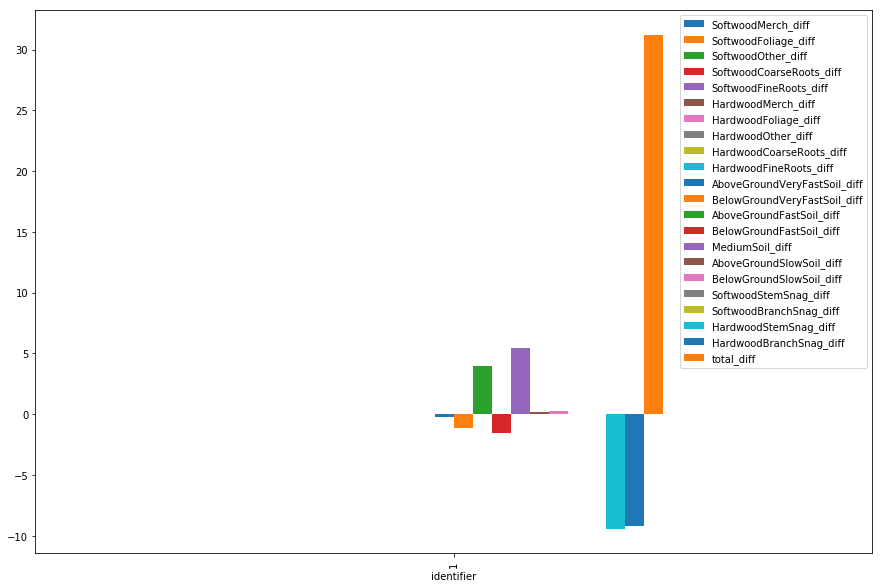

In [12]:
merged[["identifier"]+diff_colnames+["total_diff"]] \
    .groupby("identifier").sum() \
    .sort_values("total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

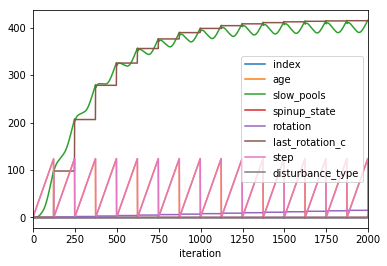

In [14]:
libCBM_spinup_debug.loc[libCBM_spinup_debug["index"]==0] \
    .groupby("iteration").sum().plot()

In [17]:
libCBM_pool_result.tail()

,index,age,Input,SoftwoodMerch,SoftwoodFoliage,SoftwoodOther,SoftwoodCoarseRoots,SoftwoodFineRoots,HardwoodMerch,HardwoodFoliage,...,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products,identifier
0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,237.639754,6.180137,...,0.0,0.0,32.204156,3.785025,17842.820246,15.120264,136.082859,0.0,0.0,1


In [13]:
cbm3_result

,TimeStep,UserDefdClassSetID,Aboveground Very Fast DOM,Belowground Very Fast DOM,Aboveground Fast DOM,Belowground Fast DOM,Medium DOM,Aboveground Slow DOM,Belowground Slow DOM,Softwood Stem Snag,...,Aboveground DOM,Belowground DOM,Deadwood,Litter,Soil C,admin,eco,identifier,species,age
0,0,1,1.856857,5.240763,41.612930,25.109430,106.986000,128.635803,275.967987,0.0,...,588.938904,306.318176,441.942780,172.105591,557.176758,Yukon Territory,Taiga Plains,1,Spruce,0
1,1,1,1.659412,4.129056,45.860611,23.580757,112.772270,128.771393,276.281952,0.0,...,580.282654,303.991760,427.571960,176.291412,556.692993,Yukon Territory,Taiga Plains,1,Spruce,1
2,2,1,1.483006,3.253172,48.985806,22.145151,118.169777,128.895874,276.539917,0.0,...,571.671143,301.938232,414.451569,179.364685,556.333008,Yukon Territory,Taiga Plains,1,Spruce,2
3,3,1,1.326372,2.563764,51.166943,20.796978,123.196465,129.004379,276.751404,0.0,...,563.130371,300.112152,402.429688,181.497696,556.066528,Yukon Territory,Taiga Plains,1,Spruce,3
4,4,1,1.188806,2.022032,52.557564,19.530954,127.869537,129.093063,276.924133,0.0,...,554.682190,298.477112,391.373718,182.839432,555.870300,Yukon Territory,Taiga Plains,1,Spruce,4
5,5,1,1.069879,1.597104,53.289631,18.342104,132.205475,129.159012,277.064240,0.0,...,546.344238,297.003448,381.167816,183.518524,555.725586,Yukon Territory,Taiga Plains,1,Spruce,5
6,6,1,0.970352,1.264999,53.476395,17.225767,136.220062,129.200089,277.176727,0.0,...,538.131775,295.667480,371.710724,183.646835,555.618408,Yukon Territory,Taiga Plains,1,Spruce,6
7,7,1,0.891977,1.006914,53.214909,16.177578,139.928406,129.214844,277.265625,0.0,...,530.058167,294.450104,362.914032,183.321732,555.538208,Yukon Territory,Taiga Plains,1,Spruce,7
8,8,1,0.837585,0.808117,52.588203,15.193439,143.345001,129.202423,277.334320,0.0,...,522.135254,293.335876,354.700470,182.628204,555.476746,Yukon Territory,Taiga Plains,1,Spruce,8
9,9,1,0.810282,0.657063,51.667175,14.269512,146.483719,129.162491,277.385498,0.0,...,514.372986,292.312073,347.002563,181.639954,555.428101,Yukon Territory,Taiga Plains,1,Spruce,9
